In [1]:
import DataLoading
from torch.utils.data import DataLoader,TensorDataset
import torch
import pandas as pd
import NN_classes
import training_methods
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sc = "sc01"
period = "2030"
folder = "../Data/RTS24_AC_12w"
all_executions = DataLoading.list_executions(folder="../Data/RTS24_AC_12w",per = period,sc=sc)
executions = all_executions[1:20]
te_s = 0.3
val_s = 0.4

In [3]:
dfs_in,dfs_out = DataLoading.load_data(folder,executions,period,sc)

input_f_sc01_Network_Line_In_N_101_N_102_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_103_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_105_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_102_N_104_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_102_N_106_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_103_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_103_N_124_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_104_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_105_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_106_N_108_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_106_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_107_N_108_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_108_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_108_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_109_N_111_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_109_N_112_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_110_N_111

In [4]:
ts_in,ts_out =  DataLoading.split_tr_val_te_by_exec(dfs_in,dfs_out,executions,te_s,val_s,False)

In [5]:
d_ft_in, d_ft_out,maxs = DataLoading.concat_and_normalize_split_by_exec(ts_in,ts_out,executions)

In [6]:
train = TensorDataset(d_ft_in['train'].float(), d_ft_out['train'].float())
validation = TensorDataset(d_ft_in['val'].float(), d_ft_out['val'].float())

training_loader = DataLoader(train,batch_size=64)
validation_loader = DataLoader(train,batch_size=64)

In [12]:
learning_rates = [0.0025/4*4**i for i in range(4)]
loss_fn = torch.nn.MSELoss()
nbs_e = [4,8,12]#,4,8]
i=0
nbs_hidden = [0,1,2,3]
dors = [0,0.05,0.1,0.2,0.4]
results = pd.DataFrame()
folder_to_save = "RTS24_AC_12w_split_by_exec_nl"
for nb_e in nbs_e:
    for lr in learning_rates:
        for nb_hidden in nbs_hidden: 
            for dor in dors:
                m = NN_classes.create_model(nb_hidden,d_ft_in['train'].shape[1],dropout_ratio= dor)
                m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor"
                optimizer = torch.optim.Adam(m.parameters(), lr=lr)
                train_loss = training_methods.train_multiple_epochs(nb_e,m,training_loader,validation_loader,loss_fn,optimizer,m_name,folder_to_save)

                saved_models = dict()

                for mt in ["min_val","all_epochs"]:
                    path = f"trained_models/{folder_to_save}/{mt}/model_{m_name}.pth"


                    model = m
                    m.load_state_dict(torch.load(path))
                    m.eval()

                    test_predictions = m(d_ft_in["test"].float())
                    test_loss = loss_fn(test_predictions.squeeze(),d_ft_out["test"])

                    train_predictions = m(d_ft_in["train"].float())
                    train_loss = loss_fn(train_predictions.squeeze(),d_ft_out["train"])

                    validation_prediction = m(d_ft_in["val"].float())
                    validation_loss = loss_fn(validation_prediction.squeeze(),d_ft_out["val"])

                    if mt == "min_val": 
                        min_val = True
                    else: 
                        min_val = False

                    r = pd.DataFrame({"Model_type": nb_hidden,
                                      "Min_val":min_val,
                                      "Epochs": nb_e,
                                      "Lr":lr,
                                      "Dor": dor,
                                      "Tr_l":train_loss.item(),
                                      "Te_l":test_loss.item(),
                                      "V_l": validation_loss.item()}
                                     ,index = [i]
                    )
                    i+=1
                    results = pd.concat([results,r])

ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
) 0 0
EPOCH 1:
  batch 1 loss: 0.0001394575834274292
  batch 101 loss: 0.0005119901264879445
  batch 201 loss: 0.00011239645680689137
LOSS train 0.0003327727220430827 valid 0.0006375726661644876
EPOCH 2:
  batch 1 loss: 7.836234544811304e-08
  batch 101 loss: 3.924097936078397e-05
  batch 201 loss: 3.46557675038639e-05
LOSS train 7.09232951172726e-05 valid 0.001110503333620727
EPOCH 3:
  batch 1 loss: 1.6329082427546383e-06
  batch 101 loss: 3.977513157337853e-05
  batch 201 loss: 3.201342332090462e-05
LOSS train 7.283109234210579e-05 valid 0.0008317824685946107
EPOCH 4:
  batch 1 loss: 1.0086051042890177e-06
  batch 101 loss: 2.7083953690407724e-05
  batch 201 loss: 3.0249493679548323e-05
LOSS train 6.76004241400873e-05 valid 0.0014173374511301517
ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=

  batch 201 loss: 0.00013355228533328044
LOSS train 0.0001402114473718036 valid 1.8365422874921933e-05
EPOCH 4:
  batch 1 loss: 9.557510202284903e-07
  batch 101 loss: 8.391858424147358e-05
  batch 201 loss: 4.147581607867323e-05
LOSS train 5.298851526473406e-05 valid 5.409151708590798e-05
ObjectiveEstimator_ANN_1hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (output_layer): Linear(in_features=35, out_features=1, bias=True)
) 0.4 1
EPOCH 1:
  batch 1 loss: 0.00020058611407876016
  batch 101 loss: 0.0006038075647666119
  batch 201 loss: 9.813552305786289e-05
LOSS train 0.0003448561226885984 valid 6.25884422333911e-05
EPOCH 2:
  batch 1 loss: 3.0793703626841307e-06
  batch 101 loss: 6.720952007526648e-05
  batch 201 loss: 6.128602792159654e-05
LOSS train 6.380582938921482e-05 valid 5.277977470541373e-05
EPOCH 3:
  batch 1 loss: 3.5408076655585317e-07
  batch 101 loss: 6.186631666423637e-05
  batch 201 los

  batch 101 loss: 0.00020695056387921797
  batch 201 loss: 0.00018810025401762686
LOSS train 0.00018647054237809932 valid 6.819558620918542e-06
EPOCH 3:
  batch 1 loss: 1.282886805711314e-06
  batch 101 loss: 0.00014148576461593622
  batch 201 loss: 0.00011581277129153023
LOSS train 0.00012214081267808777 valid 2.7460637284093536e-05
EPOCH 4:
  batch 1 loss: 4.992588583263569e-07
  batch 101 loss: 9.17105015469133e-05
  batch 201 loss: 7.773310866468819e-05
LOSS train 8.095157299510155e-05 valid 5.260132638795767e-06
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=19, out_features=1, bias=True)
) 0.1 3
EPOCH 1:
  batch 1 loss: 0.00025453863665461543
  batch 101 loss: 0.0011954546126071363
  batch 201 loss: 

  batch 201 loss: 3.8747176113247405e-05
LOSS train 4.344046148630379e-05 valid 2.8415495762601495e-05
EPOCH 4:
  batch 1 loss: 1.084995710698422e-07
  batch 101 loss: 3.3489210891275435e-05
  batch 201 loss: 3.8968689568719125e-05
LOSS train 4.208072621142971e-05 valid 3.781074701691978e-05
ObjectiveEstimator_ANN_1hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=35, out_features=1, bias=True)
) 0 1
EPOCH 1:
  batch 1 loss: 4.428256303071976e-05
  batch 101 loss: 0.001188588150725991
  batch 201 loss: 9.952167056326289e-06
LOSS train 0.00045910945230126 valid 1.6304671589750797e-05
EPOCH 2:
  batch 1 loss: 3.453534372965805e-07
  batch 101 loss: 5.872306595051668e-06
  batch 201 loss: 2.5579361508221155e-06
LOSS train 4.584649877391205e-06 valid 1.294404955842765e-05
EPOCH 3:
  batch 1 loss: 3.238678618799895e-07
  batch 101 loss: 3.9664170100195405e-06
  batch 201 loss: 1

  batch 101 loss: 0.0001155479196268061
  batch 201 loss: 0.00011476270923679977
LOSS train 0.00011606774742661787 valid 9.05273700482212e-05
ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
) 0.2 2
EPOCH 1:
  batch 1 loss: 0.0019107469916343689
  batch 101 loss: 0.03478788926266134
  batch 201 loss: 0.010944743012078106
LOSS train 0.018422813299743136 valid 0.000912196293938905
EPOCH 2:
  batch 1 loss: 2.1066481713205577e-05
  batch 101 loss: 0.0012516781507292763
  batch 201 loss: 0.00040864225054974666
LOSS train 0.0006824986027419779 valid 6.958851736271754e-05
EPOCH 3:
  batch 1 loss: 1.8030601495411248e-06
  batch 101 loss: 0.00019932839706598315
  batch 201 loss: 9.3927280868229e-05
LOSS train 0.0001267496553713826 valid 5.094232255942188e-05


  batch 101 loss: 0.0005567665042940462
  batch 201 loss: 0.0001832452890039349
LOSS train 0.000353350696003549 valid 0.0020886966958642006
EPOCH 3:
  batch 1 loss: 5.59716671705246e-05
  batch 101 loss: 0.0006198380421074034
  batch 201 loss: 0.00020435403872170354
LOSS train 0.0003601369322381781 valid 0.0021153355482965708
EPOCH 4:
  batch 1 loss: 5.488123744726181e-05
  batch 101 loss: 0.0008453301915460542
  batch 201 loss: 0.0002542031439725179
LOSS train 0.0005054444384138781 valid 0.0018586020451039076
ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
) 0.05 0
EPOCH 1:
  batch 1 loss: 0.0001462587248533964
  batch 101 loss: 0.11709503446007147
  batch 201 loss: 0.00157985549303703
LOSS train 0.043824166362472355 valid 0.00015192906721495092
EPOCH 2:
  batch 1 loss: 1.193690113723278e-05
  batch 101 loss: 0.0008078990445937962
  batch 201 loss: 0.000497339429857675
LOSS train 0.0

  batch 101 loss: 0.005754436559491296
  batch 201 loss: 0.00011253094365201832
LOSS train 0.0022559062263765193 valid 8.023683039937168e-05
EPOCH 2:
  batch 1 loss: 9.892374509945512e-07
  batch 101 loss: 0.0001260224954859268
  batch 201 loss: 0.0001222746533213126
LOSS train 0.00012107235411938649 valid 5.20052490173839e-05
EPOCH 3:
  batch 1 loss: 1.261820762010757e-07
  batch 101 loss: 0.00010142972198934786
  batch 201 loss: 8.734480517546218e-05
LOSS train 8.930185364989408e-05 valid 9.343666170025244e-05
EPOCH 4:
  batch 1 loss: 5.3792523431184234e-08
  batch 101 loss: 7.260754221988464e-05
  batch 201 loss: 6.588944291820554e-05
LOSS train 6.642635672371078e-05 valid 0.0001289426872972399
ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
) 0 2


ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=19, out_features=1, bias=True)
) 0.1 3
EPOCH 1:
  batch 1 loss: 0.00023758742958307266
  batch 101 loss: 0.013940167616819963
  batch 201 loss: 0.0002184900184511207
LOSS train 0.005291576724850309 valid 6.51756563456729e-05
EPOCH 2:
  batch 1 loss: 6.641569780185818e-07
  batch 101 loss: 9.087486183716465e-05
  batch 201 loss: 9.549008144858817e-05
LOSS train 9.62414615886594e-05 valid 8.570985664846376e-05
EPOCH 3:
  batch 1 loss: 1.0481724166311324e-06
  batch 101 loss: 0.000111364774104743
  batch 201 loss: 0.00011770258600563466
LOSS train 0.00011794038046134999 valid 8.435355266556144e-05
EPOCH 4:
  batch 1 loss: 1.0644562280504033e-06
  batch 101 loss: 

  batch 201 loss: 2.4803413303970956e-05
LOSS train 0.680285205741769 valid 8.66066875460092e-06
EPOCH 2:
  batch 1 loss: 8.267349585366901e-08
  batch 101 loss: 8.449761279223367e-06
  batch 201 loss: 1.4998786654984997e-05
LOSS train 1.103613542719132e-05 valid 3.7760171380796237e-06
EPOCH 3:
  batch 1 loss: 1.1701133644237415e-08
  batch 101 loss: 5.748940334598274e-05
  batch 201 loss: 0.00017847589786356365
LOSS train 0.00011473221268138265 valid 5.408512606663862e-06
EPOCH 4:
  batch 1 loss: 4.540333520708373e-08
  batch 101 loss: 0.00014820174290548495
  batch 201 loss: 6.88432357480906e-05
LOSS train 0.00011504711308725912 valid 1.4333167200675234e-05
ObjectiveEstimator_ANN_1hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (output_layer): Linear(in_features=35, out_features=1, bias=True)
) 0.05 1
EPOCH 1:
  batch 1 loss: 0.0003929849341511726
  batch 101 loss: 0.1744627830911304
  batch 201 loss:

  batch 101 loss: 7.397877962830534e-05
  batch 201 loss: 7.988102311628608e-05
LOSS train 7.894217081632836e-05 valid 6.996993761276826e-05
EPOCH 3:
  batch 1 loss: 7.938225462567061e-07
  batch 101 loss: 9.099668796352489e-05
  batch 201 loss: 9.752369921670833e-05
LOSS train 9.717082684260059e-05 valid 8.507876191288233e-05
EPOCH 4:
  batch 1 loss: 1.0772890527732671e-06
  batch 101 loss: 0.00011003481265646542
  batch 201 loss: 0.00011556623295405188
LOSS train 0.00011599799346915225 valid 8.762137440498918e-05
ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
) 0.4 2
EPOCH 1:
  batch 1 loss: 0.0005780395120382309
  batch 101 loss: 0.11336269191331666
  batch 201 loss: 0.00011609395927735022
LOSS train 0.0418130113800174 valid 8.764627273194492e-0

LOSS train 0.00011759626719475862 valid 0.00047436068416573107
EPOCH 6:
  batch 1 loss: 2.7920373249799012e-05
  batch 101 loss: 0.0002481382960860401
  batch 201 loss: 1.2604252440269192e-05
LOSS train 0.00011654425477108017 valid 0.00047203435678966343
EPOCH 7:
  batch 1 loss: 2.7176160365343094e-05
  batch 101 loss: 0.00024455022176539387
  batch 201 loss: 1.2665668601243851e-05
LOSS train 0.0001140768224467381 valid 0.0004672037030104548
EPOCH 8:
  batch 1 loss: 2.567588118836284e-05
  batch 101 loss: 0.00023972433940258497
  batch 201 loss: 1.263084528602576e-05
LOSS train 0.00011095619950027127 valid 0.00045926557504571974
ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
) 0.05 0
EPOCH 1:
  batch 1 loss: 0.00010949384421110153
  batch 101 loss: 0.002646983191370964
  batch 201 loss: 0.001846798756159842
LOSS train 0.0020771501912059936 valid 0.0006062532775104046
EPOCH 2:
  batch

  batch 201 loss: 1.9010940386294804e-05
LOSS train 1.4612341625550324e-05 valid 5.023682024329901e-05
EPOCH 5:
  batch 1 loss: 2.004319685511291e-07
  batch 101 loss: 1.419796497657444e-05
  batch 201 loss: 1.797499294411864e-05
LOSS train 1.3841307495384658e-05 valid 6.132412818260491e-05
EPOCH 6:
  batch 1 loss: 1.0934937563433778e-07
  batch 101 loss: 1.789963754049495e-05
  batch 201 loss: 1.656595197829347e-05
LOSS train 1.4756410415815474e-05 valid 4.182081829640083e-05
EPOCH 7:
  batch 1 loss: 4.953582538291812e-07
  batch 101 loss: 2.8589486729515555e-05
  batch 201 loss: 2.002691566218573e-05
LOSS train 2.0102951162155415e-05 valid 3.7678742955904454e-05
EPOCH 8:
  batch 1 loss: 4.0270249883178623e-07
  batch 101 loss: 2.574253083992062e-05
  batch 201 loss: 1.8103872769188456e-05
LOSS train 1.844047596433074e-05 valid 3.5002263757633045e-05
ObjectiveEstimator_ANN_1hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (dropout): Dropout(p=0.0

  batch 101 loss: 0.00010729939893053598
  batch 201 loss: 1.663073221720879e-05
LOSS train 4.74170535818176e-05 valid 1.511526988906553e-05
EPOCH 2:
  batch 1 loss: 1.9441420135990485e-08
  batch 101 loss: 6.838668825537298e-06
  batch 201 loss: 4.455829457867822e-06
LOSS train 4.777768609291769e-06 valid 8.487585546390619e-06
EPOCH 3:
  batch 1 loss: 7.422142402901955e-09
  batch 101 loss: 2.866479009355771e-06
  batch 201 loss: 2.170696416641249e-06
LOSS train 2.2637946681214043e-06 valid 5.356633664632682e-06
EPOCH 4:
  batch 1 loss: 7.387953360193933e-09
  batch 101 loss: 2.548432289302127e-06
  batch 201 loss: 1.9464415942138657e-06
LOSS train 2.0588562548894784e-06 valid 5.1922202146670315e-06
EPOCH 5:
  batch 1 loss: 7.041159619802784e-09
  batch 101 loss: 2.4880913586855513e-06
  batch 201 loss: 1.9056870858946695e-06
LOSS train 2.04636023994141e-06 valid 4.592891855281778e-06
EPOCH 6:
  batch 1 loss: 7.0970929755276305e-09
  batch 101 loss: 2.673738969178885e-06
  batch 201 l

  batch 201 loss: 0.00022591114407987333
LOSS train 0.00023999582950410436 valid 8.839728980092332e-05
EPOCH 7:
  batch 1 loss: 1.3604329433292151e-06
  batch 101 loss: 0.0001442908899844042
  batch 201 loss: 0.0001137436572025763
LOSS train 0.000119520889005292 valid 7.796514546498656e-05
EPOCH 8:
  batch 1 loss: 4.0655249904375524e-07
  batch 101 loss: 7.821052322469768e-05
  batch 201 loss: 6.507331703687668e-05
LOSS train 6.767577595269774e-05 valid 6.435481191147119e-05
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=19, out_features=1, bias=True)
) 0 3
EPOCH 1:
  batch 1 loss: 5.241946317255497e-05
  batch 101 loss: 6.16342726016228e-05
  batch 201 loss: 2.069693101816483e-05
LOSS train 5.32346720729537

  batch 101 loss: 0.0005429196584736929
  batch 201 loss: 0.0001818451330473181
LOSS train 0.00032255141199489666 valid 0.00010151851893169805
EPOCH 2:
  batch 1 loss: 1.3280331040732563e-06
  batch 101 loss: 0.00011142511873913464
  batch 201 loss: 8.737257599932491e-05
LOSS train 9.579041404618699e-05 valid 6.577459862455726e-05
EPOCH 3:
  batch 1 loss: 5.798841812065803e-07
  batch 101 loss: 7.3315851868756e-05
  batch 201 loss: 6.88007256576384e-05
LOSS train 6.954259114846226e-05 valid 5.5647920817136765e-05
EPOCH 4:
  batch 1 loss: 4.235996311763301e-07
  batch 101 loss: 6.727468660756131e-05
  batch 201 loss: 6.629348077694885e-05
LOSS train 6.605143372349304e-05 valid 5.512834832188673e-05
EPOCH 5:
  batch 1 loss: 4.211371197015978e-07
  batch 101 loss: 6.581439831279567e-05
  batch 201 loss: 6.639800945777096e-05
LOSS train 6.549560296265647e-05 valid 5.5185588280437514e-05
EPOCH 6:
  batch 1 loss: 4.2961793951690196e-07
  batch 101 loss: 6.573482215571858e-05
  batch 201 loss

  batch 101 loss: 0.01373852459480986
  batch 201 loss: 0.000331088293241919
LOSS train 0.005303230822884984 valid 2.560188113420736e-05
EPOCH 2:
  batch 1 loss: 1.0360157466493548e-06
  batch 101 loss: 4.691162912422442e-05
  batch 201 loss: 3.627223868534202e-05
LOSS train 4.2899975118742965e-05 valid 6.603272777283564e-05
EPOCH 3:
  batch 1 loss: 1.0158565419260413e-06
  batch 101 loss: 3.136648974759737e-05
  batch 201 loss: 3.548836307800229e-05
LOSS train 3.302782261682842e-05 valid 2.6999903639080003e-05
EPOCH 4:
  batch 1 loss: 3.4850079828174784e-07
  batch 101 loss: 5.849275560649403e-05
  batch 201 loss: 7.756268848424952e-05
LOSS train 7.30207797320103e-05 valid 1.6098516425699927e-05
EPOCH 5:
  batch 1 loss: 3.199723141733557e-07
  batch 101 loss: 0.00016795704027572356
  batch 201 loss: 0.00019649787380330964
LOSS train 0.0002162485257381027 valid 0.00021624487999361008
EPOCH 6:
  batch 1 loss: 2.6438984787091614e-06
  batch 101 loss: 0.00030565257704438407
  batch 201 lo

  batch 101 loss: 4.6144962593075436e-05
  batch 201 loss: 5.218685663862743e-05
LOSS train 4.846776678065438e-05 valid 3.022369673999492e-05
ObjectiveEstimator_ANN_1hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (output_layer): Linear(in_features=35, out_features=1, bias=True)
) 0.4 1
EPOCH 1:
  batch 1 loss: 0.000354030579328537
  batch 101 loss: 0.006493928509007674
  batch 201 loss: 0.0001812269454080706
LOSS train 0.0025826138593811766 valid 1.5224645721900743e-05
EPOCH 2:
  batch 1 loss: 1.3861847037333063e-07
  batch 101 loss: 2.9513960316762678e-05
  batch 201 loss: 5.823337807214557e-05
LOSS train 4.894426426486568e-05 valid 5.475004218169488e-05
EPOCH 3:
  batch 1 loss: 4.2655461584217847e-07
  batch 101 loss: 6.71658691499033e-05
  batch 201 loss: 6.943387229057407e-05
LOSS train 6.859699648481889e-05 valid 5.8126654039369896e-05
EPOCH 4:
  batch 1 loss: 5.252243863651528e-07
  batch 101 loss

  batch 101 loss: 0.0001127017165637767
  batch 201 loss: 0.00011262542213756888
LOSS train 0.00011369031731820899 valid 8.990479545900598e-05
EPOCH 5:
  batch 1 loss: 1.161266991402954e-06
  batch 101 loss: 0.00011394645857478735
  batch 201 loss: 0.00011352770482858432
LOSS train 0.00011470381396803023 valid 9.017482079798356e-05
EPOCH 6:
  batch 1 loss: 1.1658985749818385e-06
  batch 101 loss: 0.000114556451376302
  batch 201 loss: 0.00011398665570851563
LOSS train 0.00011521424115497148 valid 9.030361252371222e-05
EPOCH 7:
  batch 1 loss: 1.1681049363687634e-06
  batch 101 loss: 0.00011488651512024717
  batch 201 loss: 0.00011424099122223197
LOSS train 0.00011549548456337889 valid 9.037180279847234e-05
EPOCH 8:
  batch 1 loss: 1.1692729458445683e-06
  batch 101 loss: 0.00011507705431313298
  batch 201 loss: 0.00011439022093895801
LOSS train 0.00011565986708885894 valid 9.041047451319173e-05
ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_featur

  batch 101 loss: 0.00011598619422670709
  batch 201 loss: 0.00011511827538811303
LOSS train 0.00011645730965199372 valid 9.05966735444963e-05
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=19, out_features=1, bias=True)
) 0.2 3
EPOCH 1:
  batch 1 loss: 0.0005055690556764603
  batch 101 loss: 0.0033182346454123037
  batch 201 loss: 0.000665197731286753
LOSS train 0.0017440823536202475 valid 0.00014338179607875645
EPOCH 2:
  batch 1 loss: 2.906790759880096e-06
  batch 101 loss: 0.0002428527138545178
  batch 201 loss: 0.00019889428513124584
LOSS train 0.00021048803537535642 valid 5.522829087567516e-05
EPOCH 3:
  batch 1 loss: 1.0513812594581395e-06
  batch 101 loss: 0.0001390473607716558
  batch 201 loss: 9.

  batch 101 loss: 1.3372468355328238e-05
  batch 201 loss: 1.7573850063854478e-05
LOSS train 1.7576152584550425e-05 valid 7.83784798841225e-06
EPOCH 6:
  batch 1 loss: 8.561000868212431e-08
  batch 101 loss: 4.8212730298473616e-05
  batch 201 loss: 0.0018401816115601833
LOSS train 0.0011260403913290443 valid 0.00031174623291008174
EPOCH 7:
  batch 1 loss: 2.2985864779911936e-06
  batch 101 loss: 0.004669118125311797
  batch 201 loss: 0.0010508188294261346
LOSS train 0.0030385172158209333 valid 0.0004045272071380168
EPOCH 8:
  batch 1 loss: 5.155734834261239e-06
  batch 101 loss: 0.0014235396929143463
  batch 201 loss: 0.0031723221675201783
LOSS train 0.0020829942485704788 valid 0.0010577880311757326
ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 0.2 0
EPOCH 1:
  batch 1 loss: 0.0006152542307972908
  batch 101 loss: 0.11120288339676336
  batch 201 loss: 0.002341052169795148
LOSS trai

  batch 201 loss: 0.00011477988633942005
LOSS train 0.00011617289324071813 valid 5.559670535149053e-05
EPOCH 4:
  batch 1 loss: 6.479703642980894e-08
  batch 101 loss: 9.816645141285108e-05
  batch 201 loss: 8.658906281766576e-05
LOSS train 8.806759958303114e-05 valid 9.030068758875132e-05
EPOCH 5:
  batch 1 loss: 4.4165026338305324e-08
  batch 101 loss: 7.450585799915643e-05
  batch 201 loss: 6.805617384316065e-05
LOSS train 6.847724411199501e-05 valid 0.00012195861927466467
EPOCH 6:
  batch 1 loss: 1.680914283497259e-07
  batch 101 loss: 6.213006527787001e-05
  batch 201 loss: 5.942873668004722e-05
LOSS train 5.9147706314760377e-05 valid 0.000147235143231228
EPOCH 7:
  batch 1 loss: 2.968603621411603e-07
  batch 101 loss: 5.751885424757575e-05
  batch 201 loss: 5.724836671959111e-05
LOSS train 5.653963889454018e-05 valid 0.0001728395582176745
EPOCH 8:
  batch 1 loss: 4.430330591276288e-07
  batch 101 loss: 5.8017750013164005e-05
  batch 201 loss: 5.9515175476008156e-05
LOSS train 5.8

  batch 101 loss: 0.00730069512850605
  batch 201 loss: 0.00047097914983169176
LOSS train 0.0032746824171769793 valid 7.976532651809976e-05
EPOCH 2:
  batch 1 loss: 8.458850061288104e-07
  batch 101 loss: 8.910348814424652e-05
  batch 201 loss: 0.00010651187898019998
LOSS train 0.00010030820874321045 valid 5.574989700107835e-05
EPOCH 3:
  batch 1 loss: 6.045763711881591e-08
  batch 101 loss: 9.760814213450431e-05
  batch 201 loss: 8.327671543838733e-05
LOSS train 8.54531512658345e-05 valid 9.89642139757052e-05
EPOCH 4:
  batch 1 loss: 7.168640422605677e-08
  batch 101 loss: 7.026442715186931e-05
  batch 201 loss: 6.388109757494931e-05
LOSS train 6.443151945211454e-05 valid 0.00013483615475706756
EPOCH 5:
  batch 1 loss: 2.308331931999419e-07
  batch 101 loss: 5.918519179431314e-05
  batch 201 loss: 5.770798260357424e-05
LOSS train 5.7215270845766e-05 valid 0.00015995270223356783
EPOCH 6:
  batch 1 loss: 3.661361915874295e-07
  batch 101 loss: 5.7538634365528196e-05
  batch 201 loss: 5.

LOSS train 7.506447232050723e-05 valid 0.00010244515578961
EPOCH 6:
  batch 1 loss: 8.815385626803618e-08
  batch 101 loss: 7.050576572964929e-05
  batch 201 loss: 6.519998601902444e-05
LOSS train 6.690280833320089e-05 valid 0.00010797222785186023
EPOCH 7:
  batch 1 loss: 1.0620664397720248e-07
  batch 101 loss: 6.704200672402294e-05
  batch 201 loss: 6.304122014284985e-05
LOSS train 6.296643207639508e-05 valid 0.00013294540985953063
EPOCH 8:
  batch 1 loss: 2.215094900748227e-07
  batch 101 loss: 5.951834408961076e-05
  batch 201 loss: 5.799351298833244e-05
LOSS train 5.748800051601776e-05 valid 0.00015565766079816967
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=19, out_features=1, bias=True)
) 0.1 3
EP

LOSS train 0.7080717325562802 valid 0.0023758569732308388
EPOCH 2:
  batch 1 loss: 3.2725951168686155e-05
  batch 101 loss: 0.0019955214083893225
  batch 201 loss: 0.0006390825231210328
LOSS train 0.001084257892909504 valid 0.000695068622007966
EPOCH 3:
  batch 1 loss: 3.096624277532101e-05
  batch 101 loss: 0.001173818867537193
  batch 201 loss: 0.00017131238611909795
LOSS train 0.000522736928003777 valid 0.00023650976072531193
EPOCH 4:
  batch 1 loss: 1.7054855125024914e-05
  batch 101 loss: 0.0005166707369971845
  batch 201 loss: 4.178368826615042e-05
LOSS train 0.00021888796419218472 valid 0.00010307542834198102
EPOCH 5:
  batch 1 loss: 7.4479496106505396e-06
  batch 101 loss: 0.00035179094953491586
  batch 201 loss: 2.8351405599096325e-05
LOSS train 0.00014905994267182604 valid 5.6784461776260287e-05
EPOCH 6:
  batch 1 loss: 4.674580413848161e-06
  batch 101 loss: 0.00022394565794456867
  batch 201 loss: 3.588680048324022e-05
LOSS train 0.000107262442407863 valid 2.492361090844497

  batch 101 loss: 0.5053385224350267
  batch 201 loss: 6.814056463554152e-05
LOSS train 0.18514864581303822 valid 5.554591552936472e-05
EPOCH 2:
  batch 1 loss: 4.5178487198427317e-07
  batch 101 loss: 6.991843188188795e-05
  batch 201 loss: 7.460587374680472e-05
LOSS train 7.36380747844373e-05 valid 6.424504681490362e-05
EPOCH 3:
  batch 1 loss: 6.727094296365976e-07
  batch 101 loss: 8.3250259997385e-05
  batch 201 loss: 8.862209082735717e-05
LOSS train 8.804977742062837e-05 valid 7.703526352997869e-05
EPOCH 4:
  batch 1 loss: 9.311703615821898e-07
  batch 101 loss: 9.900060924110221e-05
  batch 201 loss: 0.00010468476055393694
LOSS train 0.00010472950047172632 valid 8.85565095813945e-05
EPOCH 5:
  batch 1 loss: 1.1380386422388255e-06
  batch 101 loss: 0.00011576294969643185
  batch 201 loss: 0.00011976647436199527
LOSS train 0.00012054750548785482 valid 8.416701894020662e-05
EPOCH 6:
  batch 1 loss: 1.0611453762976452e-06
  batch 101 loss: 0.00012710779752211465
  batch 201 loss: 0.

LOSS train 4.98947118752194e-05 valid 5.095727101434022e-05
EPOCH 8:
  batch 1 loss: 1.8876196918427014e-07
  batch 101 loss: 5.182689886623848e-05
  batch 201 loss: 5.143432594934438e-05
LOSS train 5.1790794457967535e-05 valid 5.088624675408937e-05
ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
) 0.05 2
EPOCH 1:
  batch 1 loss: 0.00156966432929039
  batch 101 loss: 0.06836553109082161
  batch 201 loss: 0.0011420014928444288
LOSS train 0.026140404917263393 valid 4.648518734029494e-05
EPOCH 2:
  batch 1 loss: 2.0466388377826663e-06
  batch 101 loss: 0.0001302882712207065
  batch 201 loss: 5.962738797279598e-05
LOSS train 8.263077873816522e-05 valid 7.510849536629394e-05
EPOCH 3:
  batch 1 loss: 2.1150683096493594e-07
  batch 101 loss: 4.53237789110

  batch 101 loss: 3.696356415758828e-06
  batch 201 loss: 2.0654261778929596e-06
LOSS train 3.608722801284921e-06 valid 1.0737044249253813e-05
EPOCH 4:
  batch 1 loss: 1.7246778952539898e-07
  batch 101 loss: 3.1141415803404014e-06
  batch 201 loss: 1.9852695687916366e-06
LOSS train 3.2981659285248594e-06 valid 6.492905413324479e-06
EPOCH 5:
  batch 1 loss: 8.048438758123666e-08
  batch 101 loss: 2.4043049192812303e-06
  batch 201 loss: 2.035178522419301e-06
LOSS train 3.2941526144969885e-06 valid 4.914637884212425e-06
EPOCH 6:
  batch 1 loss: 2.9858276775485137e-08
  batch 101 loss: 2.825306785751991e-06
  batch 201 loss: 2.4580124703277307e-06
LOSS train 3.6977498562909213e-06 valid 1.1820156942121685e-05
EPOCH 7:
  batch 1 loss: 1.607689046068117e-07
  batch 101 loss: 3.5134538273950966e-06
  batch 201 loss: 2.2937572863668265e-06
LOSS train 4.0367989179180815e-06 valid 1.2547881851787679e-05
EPOCH 8:
  batch 1 loss: 2.0961551854270511e-07
  batch 101 loss: 3.3622535471522496e-06
  

  batch 101 loss: 6.076202885196835e-05
  batch 201 loss: 6.107619904469175e-05
LOSS train 6.01613316672435e-05 valid 5.209857044974342e-05
EPOCH 8:
  batch 1 loss: 5.436140781966969e-07
  batch 101 loss: 6.084264562559838e-05
  batch 201 loss: 6.1469293814298e-05
LOSS train 6.067458349413851e-05 valid 5.251225229585543e-05
ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
) 0 0
EPOCH 1:
  batch 1 loss: 1.0340864537283779e-05
  batch 101 loss: 0.00042466890968171354
  batch 201 loss: 0.00014222666563910025
LOSS train 0.0002775821967105789 valid 0.0009519557352177799
EPOCH 2:
  batch 1 loss: 1.6839827876538037e-05
  batch 101 loss: 9.747534445750717e-05
  batch 201 loss: 5.585441487824028e-05
LOSS train 0.00013831745937149052 valid 0.0017556286184117198
EPOCH 3:
  batch 1 loss: 2.703203819692135e-05
  batch 101 loss: 0.00015555515390815343
  batch 201 loss: 5.2108781194419865e-05
LOSS train

  batch 101 loss: 4.8512803732592144e-05
  batch 201 loss: 1.9504482716001802e-05
LOSS train 2.9329083950110393e-05 valid 1.3213955753599294e-05
EPOCH 4:
  batch 1 loss: 2.8085196390748024e-07
  batch 101 loss: 1.851550234732713e-05
  batch 201 loss: 1.371692612337938e-05
LOSS train 1.5327853408309285e-05 valid 1.4128934708423913e-05
EPOCH 5:
  batch 1 loss: 8.813525710138493e-08
  batch 101 loss: 1.2278108986265579e-05
  batch 201 loss: 1.227825476689759e-05
LOSS train 1.2448257770228714e-05 valid 2.3490996682085097e-05
EPOCH 6:
  batch 1 loss: 8.268804776889738e-08
  batch 101 loss: 1.39882081361975e-05
  batch 201 loss: 1.3299074475980888e-05
LOSS train 1.5791268998284414e-05 valid 3.67284010280855e-05
EPOCH 7:
  batch 1 loss: 1.410457662132103e-07
  batch 101 loss: 2.2661973616777686e-05
  batch 201 loss: 2.6864686410590367e-05
LOSS train 2.4058515918190323e-05 valid 1.0507947081350721e-05
EPOCH 8:
  batch 1 loss: 1.3013520401727875e-07
  batch 101 loss: 1.2795109366834367e-05
  ba

  batch 101 loss: 1.5272134678525617e-05
  batch 201 loss: 1.5117553898562619e-05
LOSS train 1.4445591503171115e-05 valid 1.1657386494334787e-05
EPOCH 8:
  batch 1 loss: 1.6023512216634117e-07
  batch 101 loss: 1.0375627125540632e-05
  batch 201 loss: 1.2009523043161608e-05
LOSS train 1.0916954751014317e-05 valid 7.052231467241654e-06
EPOCH 9:
  batch 1 loss: 1.6031006452976726e-07
  batch 101 loss: 8.282110163690959e-06
  batch 201 loss: 9.970094797608908e-06
LOSS train 9.00019388246376e-06 valid 6.9296274887165055e-06
EPOCH 10:
  batch 1 loss: 8.197488568839617e-08
  batch 101 loss: 7.495947290863114e-06
  batch 201 loss: 8.800651260116865e-06
LOSS train 7.733688681955988e-06 valid 1.3407959158939775e-05
EPOCH 11:
  batch 1 loss: 2.267308263981249e-07
  batch 101 loss: 7.488726203064288e-06
  batch 201 loss: 8.950234754365738e-06
LOSS train 8.073051941416548e-06 valid 1.0370855306973681e-05
EPOCH 12:
  batch 1 loss: 1.818191412894521e-07
  batch 101 loss: 7.944497338030487e-06
  batc

LOSS train 2.8251378377314518e-05 valid 1.3910489542467985e-05
EPOCH 11:
  batch 1 loss: 8.013007573026698e-08
  batch 101 loss: 2.5446150399375256e-05
  batch 201 loss: 2.9019400963079533e-05
LOSS train 2.7245879430785743e-05 valid 1.6073126971605234e-05
EPOCH 12:
  batch 1 loss: 1.1857477147714235e-07
  batch 101 loss: 2.9180997989897152e-05
  batch 201 loss: 2.9188643011366367e-05
LOSS train 2.928491015974122e-05 valid 1.5060250007081777e-05
ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
) 0 2
EPOCH 1:
  batch 1 loss: 0.00011012151837348938
  batch 101 loss: 0.00010917243304675139
  batch 201 loss: 6.570407106892161e-05
LOSS train 0.0001181575843110205 valid 0.00016596150817349553
EPOCH 2:
  batch 1 loss: 4.099848592886701e-07
  batch 101 loss: 4.

  batch 101 loss: 0.036481432467699054
  batch 201 loss: 0.011765480530448258
LOSS train 0.02064476894289801 valid 0.0017341045895591378
EPOCH 2:
  batch 1 loss: 6.559544242918492e-05
  batch 101 loss: 0.007408104538917541
  batch 201 loss: 0.005181857293937355
LOSS train 0.0056955333178242045 valid 0.0006489641382358968
EPOCH 3:
  batch 1 loss: 3.340987488627434e-05
  batch 101 loss: 0.0029397303063888104
  batch 201 loss: 0.0019391281809657812
LOSS train 0.002159608616288956 valid 0.00015098937728907913
EPOCH 4:
  batch 1 loss: 8.369781426154077e-06
  batch 101 loss: 0.0009445687054540031
  batch 201 loss: 0.000604990849387832
LOSS train 0.0006703703596867321 valid 4.154006819589995e-05
EPOCH 5:
  batch 1 loss: 2.6662222808226942e-06
  batch 101 loss: 0.0002655311498529045
  batch 201 loss: 0.00017479843489127234
LOSS train 0.0001929849866748235 valid 2.5428011213080026e-05
EPOCH 6:
  batch 1 loss: 8.588893251726404e-07
  batch 101 loss: 9.232806976797292e-05
  batch 201 loss: 6.8747

  batch 101 loss: 6.82967798820755e-05
  batch 201 loss: 5.2670362256321825e-05
LOSS train 5.59533981929598e-05 valid 2.22954749915516e-05
EPOCH 4:
  batch 1 loss: 3.8420730561483654e-07
  batch 101 loss: 3.640181626906269e-05
  batch 201 loss: 2.76177252362686e-05
LOSS train 2.9205597420247576e-05 valid 6.749446583853569e-06
EPOCH 5:
  batch 1 loss: 2.0640569346142e-07
  batch 101 loss: 1.846570332418196e-05
  batch 201 loss: 1.3979075683892006e-05
LOSS train 1.4790308725570115e-05 valid 3.2159873626369517e-06
EPOCH 6:
  batch 1 loss: 8.214349691115785e-08
  batch 101 loss: 9.24824671301394e-06
  batch 201 loss: 7.490380839954014e-06
LOSS train 7.66726601514598e-06 valid 2.259122311443207e-06
EPOCH 7:
  batch 1 loss: 8.400947990594431e-08
  batch 101 loss: 5.4657196483276494e-06
  batch 201 loss: 4.458928029862363e-06
LOSS train 4.712229613457796e-06 valid 1.9058309135289164e-06
EPOCH 8:
  batch 1 loss: 3.903222477674717e-08
  batch 101 loss: 3.723431173625613e-06
  batch 201 loss: 3.

  batch 101 loss: 9.074524386960547e-05
  batch 201 loss: 7.84779644527589e-05
LOSS train 8.169293224644927e-05 valid 4.306925620767288e-05
EPOCH 6:
  batch 1 loss: 5.802596933790483e-07
  batch 101 loss: 6.887942960929649e-05
  batch 201 loss: 6.532889641675865e-05
LOSS train 6.508264234251148e-05 valid 3.55999763996806e-05
EPOCH 7:
  batch 1 loss: 3.591495988075621e-07
  batch 101 loss: 5.976473755254119e-05
  batch 201 loss: 5.1430307335067484e-05
LOSS train 5.254134993808357e-05 valid 2.5912448109011166e-05
EPOCH 8:
  batch 1 loss: 2.3389080524793826e-07
  batch 101 loss: 4.13955387648457e-05
  batch 201 loss: 4.238068946506246e-05
LOSS train 4.1296283254915236e-05 valid 1.9486795281409286e-05
EPOCH 9:
  batch 1 loss: 1.952082493517082e-07
  batch 101 loss: 3.6986386539865635e-05
  batch 201 loss: 3.9199619091050406e-05
LOSS train 3.7728864950729274e-05 valid 2.167717320844531e-05
EPOCH 10:
  batch 1 loss: 1.996546779992059e-07
  batch 101 loss: 3.713082539889001e-05
  batch 201 lo

  batch 201 loss: 0.000381143984686787
LOSS train 0.00021133720119306107 valid 3.5717053833650425e-05
EPOCH 11:
  batch 1 loss: 7.290799112524837e-07
  batch 101 loss: 7.755999451092066e-05
  batch 201 loss: 0.00012515042724771773
LOSS train 0.00012749676788965627 valid 1.3452349776343908e-05
EPOCH 12:
  batch 1 loss: 8.559765774407424e-08
  batch 101 loss: 9.283214901643078e-05
  batch 201 loss: 0.00032871004578282736
LOSS train 0.00018891953931458936 valid 6.706442218273878e-05
ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 0.2 0
EPOCH 1:
  batch 1 loss: 0.00024601109325885775
  batch 101 loss: 0.010329051986336707
  batch 201 loss: 0.0013483673124574124
LOSS train 0.004456809471626152 valid 0.00015451091167051345
EPOCH 2:
  batch 1 loss: 1.1281748302280902e-05
  batch 101 loss: 0.00014756863766706373
  batch 201 loss: 2.6475513514014893e-05
LOSS train 7.626043644939692e-05 valid 

LOSS train 0.00029450588875082454 valid 7.607421139255166e-05
EPOCH 2:
  batch 1 loss: 9.083812619792298e-07
  batch 101 loss: 9.118060195362432e-05
  batch 201 loss: 9.308055943165528e-05
LOSS train 9.356172396820634e-05 valid 8.0974365118891e-05
EPOCH 3:
  batch 1 loss: 1.0035392188001424e-06
  batch 101 loss: 0.00010107728014645545
  batch 201 loss: 0.00010456148990897418
LOSS train 0.00010431631533756712 valid 8.618749416200444e-05
EPOCH 4:
  batch 1 loss: 1.0967942216666415e-06
  batch 101 loss: 0.00010811987261263311
  batch 201 loss: 0.00010905496763882638
LOSS train 0.000109764661709795 valid 8.848767902236432e-05
EPOCH 5:
  batch 1 loss: 1.1368485138518735e-06
  batch 101 loss: 0.00011132880602417572
  batch 201 loss: 0.00011146970057893669
LOSS train 0.00011244320722797443 valid 8.945740410126746e-05
EPOCH 6:
  batch 1 loss: 1.1535787780303508e-06
  batch 101 loss: 0.00011300179778942266
  batch 201 loss: 0.00011275261204872322
LOSS train 0.00011386103481888709 valid 8.991085

  batch 101 loss: 0.0001088705878186147
  batch 201 loss: 0.00010949152054081424
LOSS train 0.0001102853706093051 valid 8.8617300207261e-05
EPOCH 6:
  batch 1 loss: 1.1390902363928035e-06
  batch 101 loss: 0.00011148268273274198
  batch 201 loss: 0.00011153191354111413
LOSS train 0.00011252732217549287 valid 8.945890294853598e-05
EPOCH 7:
  batch 1 loss: 1.1536035890458152e-06
  batch 101 loss: 0.0001129820609034482
  batch 201 loss: 0.00011271225543779906
LOSS train 0.00011382330083531725 valid 8.988765330286697e-05
EPOCH 8:
  batch 1 loss: 1.160973042715341e-06
  batch 101 loss: 0.00011387311718777938
  batch 201 loss: 0.00011341938021530495
LOSS train 0.00011459872673867305 valid 9.01204111869447e-05
EPOCH 9:
  batch 1 loss: 1.1649659427348525e-06
  batch 101 loss: 0.00011441860875152087
  batch 201 loss: 0.00011385523432608124
LOSS train 0.00011507613118087048 valid 9.025375766213983e-05
EPOCH 10:
  batch 1 loss: 1.1672509572235867e-06
  batch 101 loss: 0.00011476051546708277
  bat

LOSS train 9.549768105732119e-05 valid 7.910999556770548e-05
EPOCH 8:
  batch 1 loss: 9.147720993496478e-07
  batch 101 loss: 9.706763338954261e-05
  batch 201 loss: 9.752495525390259e-05
LOSS train 9.781274824933625e-05 valid 7.953329622978345e-05
EPOCH 9:
  batch 1 loss: 9.04091793927364e-07
  batch 101 loss: 0.0001000232299156778
  batch 201 loss: 9.848196356642802e-05
LOSS train 0.00010056836232008755 valid 8.382538362639025e-05
EPOCH 10:
  batch 1 loss: 1.1732837447198109e-06
  batch 101 loss: 0.00010459635089262065
  batch 201 loss: 0.00010330925807750191
LOSS train 0.0001051092897883098 valid 8.512990461895242e-05
EPOCH 11:
  batch 1 loss: 1.0652728815330192e-06
  batch 101 loss: 0.00010525786057883124
  batch 201 loss: 0.00010320116530692757
LOSS train 0.00010470584070581593 valid 8.428803994320333e-05
EPOCH 12:
  batch 1 loss: 1.0369758820161224e-06
  batch 101 loss: 0.00010574523349532683
  batch 201 loss: 0.00010577686655778962
LOSS train 0.00010558274959457309 valid 7.88065

  batch 101 loss: 3.603670191409947e-06
  batch 201 loss: 1.544050621760107e-06
LOSS train 2.207694272180141e-06 valid 9.526318081043428e-07
EPOCH 11:
  batch 1 loss: 7.038405556158978e-09
  batch 101 loss: 1.043656090331524e-06
  batch 201 loss: 8.676659235362649e-07
LOSS train 1.0769977198938183e-06 valid 1.3416845376923447e-06
EPOCH 12:
  batch 1 loss: 1.157631004389259e-08
  batch 101 loss: 1.2951783113379633e-06
  batch 201 loss: 7.880601819465483e-07
LOSS train 1.2560453282232144e-06 valid 1.4666892411696608e-06
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (output_layer): Linear(in_features=19, out_features=1, bias=True)
) 0.05 3
EPOCH 1:
  batch 1 loss: 0.0004083611816167831
  batch 101 loss: 0.0014609766664216296
  batch 201 loss

  batch 201 loss: 0.00011479171795002686
LOSS train 0.00011512257543522903 valid 8.980194252217188e-05
EPOCH 12:
  batch 1 loss: 1.1553828517207875e-06
  batch 101 loss: 0.00011555045420834631
  batch 201 loss: 0.0001148030294768887
LOSS train 0.00011600149568286704 valid 9.029664943227544e-05
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (output_layer): Linear(in_features=19, out_features=1, bias=True)
) 0.4 3
EPOCH 1:
  batch 1 loss: 0.0006940187513828277
  batch 101 loss: 0.004952141008106992
  batch 201 loss: 0.0006752526835771277
LOSS train 0.002387221591421761 valid 5.1145303586963564e-05
EPOCH 2:
  batch 1 loss: 1.4608202036470175e-06
  batch 101 loss: 0.00018254271111800335
  batch 201 loss: 0.00012311208232858916
LOSS train 0.0001

  batch 201 loss: 0.0001641921765258303
LOSS train 0.0002872589309032471 valid 1.2608229553734418e-05
EPOCH 3:
  batch 1 loss: 1.059956193785183e-06
  batch 101 loss: 6.837968558102148e-05
  batch 201 loss: 1.7365543790219818e-05
LOSS train 3.70675466218104e-05 valid 2.0204755855957046e-05
EPOCH 4:
  batch 1 loss: 6.285057315835729e-07
  batch 101 loss: 2.0508279112618767e-05
  batch 201 loss: 1.1949356837703817e-05
LOSS train 1.6248227668936354e-05 valid 7.924699275463354e-06
EPOCH 5:
  batch 1 loss: 6.33636682323413e-08
  batch 101 loss: 2.8242251946721808e-05
  batch 201 loss: 2.588942372312886e-05
LOSS train 2.8631279117409857e-05 valid 6.045687314326642e-06
EPOCH 6:
  batch 1 loss: 1.6676995073794387e-07
  batch 101 loss: 6.240863221592008e-05
  batch 201 loss: 0.0006917945806162606
LOSS train 0.0026346005723168605 valid 0.0029878150671720505
EPOCH 7:
  batch 1 loss: 3.997991792857647e-05
  batch 101 loss: 0.001663526270276634
  batch 201 loss: 0.00021245552045002114
LOSS train 0.

  batch 101 loss: 0.00012201778159692366
  batch 201 loss: 0.00011438778475167055
LOSS train 0.00011590195358097005 valid 5.210454037296586e-05
EPOCH 8:
  batch 1 loss: 1.2533730114228093e-07
  batch 101 loss: 0.0001053786260445122
  batch 201 loss: 9.646073979865832e-05
LOSS train 9.759290702150616e-05 valid 7.020466728135943e-05
EPOCH 9:
  batch 1 loss: 1.1731995073205326e-08
  batch 101 loss: 8.681092887741215e-05
  batch 201 loss: 7.9576249549973e-05
LOSS train 8.01327331042964e-05 valid 9.62938938755542e-05
EPOCH 10:
  batch 1 loss: 6.288506483542733e-08
  batch 101 loss: 7.220244026029832e-05
  batch 201 loss: 6.745025922555214e-05
LOSS train 6.748431652813585e-05 valid 0.0001201373670483008
EPOCH 11:
  batch 1 loss: 1.5960984455887229e-07
  batch 101 loss: 6.2872843373043e-05
  batch 201 loss: 6.032004665257773e-05
LOSS train 5.9961333523300866e-05 valid 0.0001411088596796617
EPOCH 12:
  batch 1 loss: 2.6398876798339186e-07
  batch 101 loss: 5.818950363732256e-05
  batch 201 los

  batch 101 loss: 6.604289132837949e-05
  batch 201 loss: 6.267248478138754e-05
LOSS train 6.245365828266379e-05 valid 0.00013265911547932774
EPOCH 12:
  batch 1 loss: 2.202822724939324e-07
  batch 101 loss: 5.9615603020120035e-05
  batch 201 loss: 5.815492571628056e-05
LOSS train 5.761170974361222e-05 valid 0.0001532068126834929
ObjectiveEstimator_ANN_1hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (output_layer): Linear(in_features=35, out_features=1, bias=True)
) 0.4 1
EPOCH 1:
  batch 1 loss: 3.819536883383989e-05
  batch 101 loss: 0.018569187594505366
  batch 201 loss: 6.775959380320273e-05
LOSS train 0.0068599511070853636 valid 6.150374247226864e-05
EPOCH 2:
  batch 1 loss: 6.098044104874134e-07
  batch 101 loss: 8.096810804772759e-05
  batch 201 loss: 8.877091710019158e-05
LOSS train 8.790968369907698e-05 valid 7.948128040879965e-05
EPOCH 3:
  batch 1 loss: 9.765591676114126e-07
  batch 101 loss:

  batch 101 loss: 0.0016012609326025995
  batch 201 loss: 0.00012236034063164424
LOSS train 0.0006625721044611139 valid 6.124791252659634e-05
EPOCH 2:
  batch 1 loss: 2.7453606890048833e-08
  batch 101 loss: 8.713301879765822e-05
  batch 201 loss: 6.974223573934068e-05
LOSS train 7.321106880388157e-05 valid 0.0001318884751526639
EPOCH 3:
  batch 1 loss: 2.1639860278810374e-07
  batch 101 loss: 5.920973296156262e-05
  batch 201 loss: 5.730012347328284e-05
LOSS train 5.7104034089116886e-05 valid 0.00017306467634625733
EPOCH 4:
  batch 1 loss: 4.443725265446119e-07
  batch 101 loss: 5.8182500013685966e-05
  batch 201 loss: 6.053524127651144e-05
LOSS train 5.945334501949376e-05 valid 0.00021728524006903172
EPOCH 5:
  batch 1 loss: 7.213325443444774e-07
  batch 101 loss: 6.476422264597658e-05
  batch 201 loss: 6.85547846967438e-05
LOSS train 6.718302818642223e-05 valid 0.0002587763301562518
EPOCH 6:
  batch 1 loss: 1.0002972703659907e-06
  batch 101 loss: 7.241923891342595e-05
  batch 201 l

  batch 201 loss: 6.938945990953016e-07
LOSS train 1.1250268102315573e-06 valid 9.023357847581792e-07
EPOCH 4:
  batch 1 loss: 4.820629442292557e-09
  batch 101 loss: 7.689045563097352e-07
  batch 201 loss: 1.3030220256382563e-06
LOSS train 1.0198498394049402e-06 valid 1.5146647456276696e-06
EPOCH 5:
  batch 1 loss: 3.840858369130729e-09
  batch 101 loss: 2.0344513099246343e-06
  batch 201 loss: 9.324324116732897e-07
LOSS train 1.2785797570581512e-06 valid 1.3588291949417908e-06
EPOCH 6:
  batch 1 loss: 3.2227225688075123e-09
  batch 101 loss: 1.0953392862234068e-06
  batch 201 loss: 7.636382575526568e-07
LOSS train 9.066725147532359e-07 valid 1.1550617955435882e-06
EPOCH 7:
  batch 1 loss: 3.5767274653153437e-09
  batch 101 loss: 8.604336257889145e-07
  batch 201 loss: 8.469770796182274e-07
LOSS train 1.1955111781187889e-06 valid 6.7892970037064515e-06
EPOCH 8:
  batch 1 loss: 2.668042725417763e-08
  batch 101 loss: 1.5321851672922547e-06
  batch 201 loss: 6.87780687158579e-07
LOSS tr

  batch 101 loss: 0.00012192951917597839
  batch 201 loss: 0.00012398343947666034
LOSS train 0.00012506399962057245 valid 7.603159610880539e-05
EPOCH 6:
  batch 1 loss: 9.122641495196149e-07
  batch 101 loss: 0.0001274953017775715
  batch 201 loss: 0.00012405588825401993
LOSS train 0.00012547106087100514 valid 5.4498494137078524e-05
EPOCH 7:
  batch 1 loss: 4.1821553168119865e-07
  batch 101 loss: 0.00011930666222951913
  batch 201 loss: 0.0001110093200816209
LOSS train 0.00011247880406791166 valid 5.438948574010283e-05
EPOCH 8:
  batch 1 loss: 7.945665856823326e-08
  batch 101 loss: 0.00010131955715252161
  batch 201 loss: 9.25094903726631e-05
LOSS train 9.354673412388735e-05 valid 7.578819349873811e-05
EPOCH 9:
  batch 1 loss: 1.4318021612780284e-08
  batch 101 loss: 8.30979145098354e-05
  batch 201 loss: 7.6561408507132e-05
LOSS train 7.689467975527499e-05 valid 0.00010203977581113577
EPOCH 10:
  batch 1 loss: 8.331871867994777e-08
  batch 101 loss: 6.983080483905723e-05
  batch 201

  batch 201 loss: 0.002462494191713631
LOSS train 0.02700626746287199 valid 0.16029709577560425
EPOCH 10:
  batch 1 loss: 0.0014485502243041992
  batch 101 loss: 0.03518465428147465
  batch 201 loss: 0.016810430136101787
LOSS train 0.03602549479090977 valid 0.00797231774777174
EPOCH 11:
  batch 1 loss: 6.25376496464014e-05
  batch 101 loss: 0.09048612594138832
  batch 201 loss: 0.017004152970621363
LOSS train 0.041297626989508125 valid 0.0056846062652766705
EPOCH 12:
  batch 1 loss: 4.5331139117479327e-05
  batch 101 loss: 0.052793078889662864
  batch 201 loss: 0.02010809832980158
LOSS train 0.038271676549208676 valid 0.003444946836680174
ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
) 0.1 0
EPOCH 1:
  batch 1 loss: 0.0001602761447429657
  batch 101 loss: 2.1138652527634987
  batch 201 loss: 0.0035363548214081674
LOSS train 0.7761543074457722 valid 0.0009932422544807196
EPOCH 2:
  ba

  batch 101 loss: 5.97449651286297e-05
  batch 201 loss: 6.157961312055704e-05
LOSS train 6.06644872001171e-05 valid 5.3644165745936334e-05
EPOCH 3:
  batch 1 loss: 3.8820169720565903e-07
  batch 101 loss: 6.460380555836309e-05
  batch 201 loss: 6.660597252448496e-05
LOSS train 6.576229452548432e-05 valid 5.627463178825565e-05
EPOCH 4:
  batch 1 loss: 4.7363162593683226e-07
  batch 101 loss: 7.005595180089585e-05
  batch 201 loss: 7.24106350207876e-05
LOSS train 7.165101304540075e-05 valid 6.0304624639684334e-05
EPOCH 5:
  batch 1 loss: 5.808504283777439e-07
  batch 101 loss: 7.661003045541293e-05
  batch 201 loss: 7.944813194171729e-05
LOSS train 7.882557707862594e-05 valid 6.62640159134753e-05
EPOCH 6:
  batch 1 loss: 7.167500007199123e-07
  batch 101 loss: 8.471640510151701e-05
  batch 201 loss: 8.811979691699889e-05
LOSS train 8.773073255431569e-05 valid 7.444252696586773e-05
EPOCH 7:
  batch 1 loss: 8.819591312203556e-07
  batch 101 loss: 9.473809999690275e-05
  batch 201 loss: 9.

  batch 101 loss: 0.00010547161528279503
  batch 201 loss: 0.0001099023129171428
LOSS train 0.00011033827082289526 valid 8.977686957223341e-05
EPOCH 7:
  batch 1 loss: 1.1590700160013511e-06
  batch 101 loss: 0.00011906608420133579
  batch 201 loss: 0.00012172294825575136
LOSS train 0.0001227974989294605 valid 8.225703641073778e-05
EPOCH 8:
  batch 1 loss: 1.027010439429432e-06
  batch 101 loss: 0.0001275183263345525
  batch 201 loss: 0.00012562854438670002
LOSS train 0.00012707290804262597 valid 6.020973887643777e-05
EPOCH 9:
  batch 1 loss: 5.785144458059221e-07
  batch 101 loss: 0.00012344196234380432
  batch 201 loss: 0.00011598346732398568
LOSS train 0.00011746434140213384 valid 5.1632439863169566e-05
EPOCH 10:
  batch 1 loss: 1.4208958418748807e-07
  batch 101 loss: 0.0001063231535988507
  batch 201 loss: 9.670100966786776e-05
LOSS train 9.791152031238575e-05 valid 7.134079351089895e-05
EPOCH 11:
  batch 1 loss: 1.1690181054291315e-08
  batch 101 loss: 8.573849820891156e-05
  bat

  batch 101 loss: 5.892128521054474e-05
  batch 201 loss: 6.154978421136547e-05
LOSS train 6.048260603113907e-05 valid 0.0002264016366098076
EPOCH 10:
  batch 1 loss: 7.812904368620366e-07
  batch 101 loss: 6.677337329733745e-05
  batch 201 loss: 7.197161154067545e-05
LOSS train 7.066478575939822e-05 valid 0.000283797417068854
EPOCH 11:
  batch 1 loss: 1.1750494013540447e-06
  batch 101 loss: 7.884229680257704e-05
  batch 201 loss: 8.305537828391607e-05
LOSS train 8.222954664187199e-05 valid 0.00028204498812556267
EPOCH 12:
  batch 1 loss: 1.162673652288504e-06
  batch 101 loss: 8.25014817041847e-05
  batch 201 loss: 7.801626541549922e-05
LOSS train 7.9079615034894e-05 valid 0.00017876170750241727
ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
) 0.

  batch 101 loss: 3.562702974591048e-05
  batch 201 loss: 3.808771968976998e-05
LOSS train 3.762362173751298e-05 valid 5.8741810789797455e-05
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=19, out_features=1, bias=True)
) 0 3
EPOCH 1:
  batch 1 loss: 4.7699245624244216e-05
  batch 101 loss: 8.977184116325697
  batch 201 loss: 0.0005316907432495555
LOSS train 3.288857172939639 valid 7.297995034605265e-05
EPOCH 2:
  batch 1 loss: 8.536313544027507e-07
  batch 101 loss: 4.398570206888053e-05
  batch 201 loss: 3.326243661604167e-05
LOSS train 3.7190280048624835e-05 valid 5.202316970098764e-05
EPOCH 3:
  batch 1 loss: 1.2787882042175625e-07
  batch 101 loss: 3.379693359590874e-05
  batch 201 loss: 3.1755501770049

  batch 101 loss: 18.654851467907427
  batch 201 loss: 0.011866285437718034
LOSS train 6.839340326047909 valid 0.002683232305571437
EPOCH 2:
  batch 1 loss: 3.7521892227232453e-05
  batch 101 loss: 0.0033824505738448353
  batch 201 loss: 0.0013175218482501805
LOSS train 0.0018948695607246293 valid 0.00020959244284313172
EPOCH 3:
  batch 1 loss: 4.8702413914725185e-06
  batch 101 loss: 0.00025097807207203005
  batch 201 loss: 0.00012574728985782714
LOSS train 0.00016087770701156615 valid 6.321914406726137e-05
EPOCH 4:
  batch 1 loss: 5.631629755953327e-07
  batch 101 loss: 6.762736487871735e-05
  batch 201 loss: 6.310342363576638e-05
LOSS train 6.3614625295296e-05 valid 5.344205055735074e-05
EPOCH 5:
  batch 1 loss: 3.5951088648289444e-07
  batch 101 loss: 6.0984025167272194e-05
  batch 201 loss: 6.0867223392051526e-05
LOSS train 6.033008594719195e-05 valid 5.2985942602390423e-05
EPOCH 6:
  batch 1 loss: 3.582498538889922e-07
  batch 101 loss: 6.154466896077793e-05
  batch 201 loss: 6.2

In [13]:
results.to_csv("Loss_results_csv/20Exec_split_by_exec_new_loss.csv")

In [ ]:
f = (results.Epochs == 12)  & (results.Model_type != 0) 
sns.boxplot(y = "Te_l",x="Dor",data = results[f],hue = "Min_val")
plt.savefig("Figures/Split_by_exec/Min_val_effect_Testloss_fDor.png")

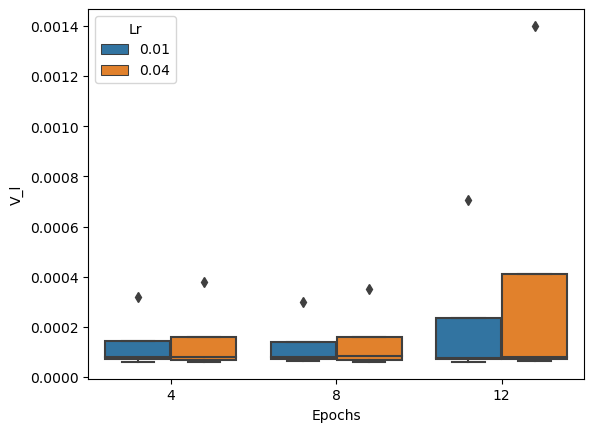

In [61]:
f =  (results.Model_type == 0) & (results.Min_val == True)
sns.boxplot(y = "V_l",x="Epochs",data = results[f],hue = "Lr")
plt.savefig("Figures/Split_by_exec/Lr_effect_Testloss_fEpochs.png")